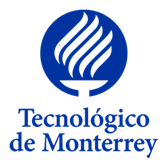

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 5

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Evaluation - Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

El objetivo de esta evaluación es medir el desempeño del modelo seleccionado usando las preguntas y respuestas sintéticas calificadas previamente.

Para evaluar el modelo seleccionado para este proyecto usando la base de datos de conocimientos en **AWS Bedrock**  se seguirá el siguiente procesp:
1. Cargar los datos de un archivo de un Bucket S3, llamado *synthetic-data/hotel-data-set-4p.snappy.parquet*
2. Pasar las preguntas sintéticas por el modelo seleccionado de **AWS Bedrock con KB V2.00**
3. Pasar las respuestas y contextos generados por el modelo seleccionado por el modelo de evaluación de RAGAs
4. Analizar los resultados


## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [1]:
!pip install pyarrow

In [2]:
!pip install openpyxl

In [3]:
!pip install langchain

In [4]:
!pip install langchain-community

In [5]:
!pip install langchain-text-splitters

In [6]:
!pip install langchain-aws

In [7]:
!pip install python-dotenv

In [8]:
!pip install pinecone-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 13.6 MB/s eta 0:00:00


In [9]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 7.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.5 MB/s eta 0:00:00


In [10]:
!pip install pip install ragas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 852.6 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.0 MB/s eta 0:00:0000:01


In [37]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import os
import time

from dotenv import load_dotenv
import pandas as pd
import numpy as np

import pyarrow.parquet as pq
import boto3
import s3fs
import openpyxl

from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.embeddings import BedrockEmbeddings
from langchain_aws import BedrockLLM

from pinecone import Pinecone
from sklearn.metrics.pairwise import cosine_similarity

from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

In [13]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../logs/Avance4_Equipo37_Bedrock_Alternative.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [14]:
# Configurando constantes para la ejecución. AWS_KBID_Vxxx contiene el identificador de la base
# de conocimientos de AWS Bedrock
load_dotenv()
MAX_ENTRIES = 100
AWS_KBID_V100 = os.environ['AWS_KBID_V100']
AWS_KBID_V200 = os.environ['AWS_KBID_V200']
PINECONE_API_KEY_V100 = os.environ['PINECONE_API_KEY_V100']
INDEX_V100 = 'volindov101'
PINECONE_API_KEY_V200 = os.environ['PINECONE_API_KEY_V200']
INDEX_V200 = 'volindov200'
KB_VERSION = '2.00'

if KB_VERSION == '1.00':
    PINDEX = INDEX_V100
    PKEY = PINECONE_API_KEY_V100
else:
    PINDEX = INDEX_V200
    PKEY = PINECONE_API_KEY_V200


### **Evaluando la Base de Conocimiento y el Modelo Fundacional Visualmente con UMAP**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas. Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Blah, Blah, Blah, Blah

### **Creando Agente para Recuperar Informacion de Contexto**

In [15]:
# Creando clientes para componentes de AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
if KB_VERSION == '1.00':
    retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=AWS_KBID_V100,
        retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 5}},
    )
else:
    retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=AWS_KBID_V200,
        retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 5}},
    )

### **Creando Agente para Questionar el Modelo Fundacional**

In [16]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
llm = BedrockLLM(model_id='amazon.titan-text-premier-v1:0', model_kwargs=model_kwargs_premier)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [17]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, retriever, llm):
    start_time = time.time()
    system_prompt = (
        "You are a friendly and helpful travel assistant. Begin your response with a polite greeting. Accurately use the detailed context provided from the database "
        "to answer the following query, particularly focusing on correct location details. Ensure the locations mentioned are verified against "
        "the context. Provide options within the same city or nearby, double-checking location accuracy. Offer two or three choices when possible. "
        "Address the user by name if provided in the context. If the answer is unknown or if you cannot verify the location details, state 'I don't know'. "
        "Limit responses to three sentences and maintain conciseness. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)
    
    response = chain.invoke({"input": query})
    elapsed_time = time.time() - start_time
    return elapsed_time, response


In [18]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['answer']}")
#    for context in response['context']:
#        print(f"\nContexto:\n{context.page_content}")
#        print(f"\nCalificacion:{context.metadata['score']:.6f}")
#        print(f"\nNombre del hotel: {context.metadata['source_metadata']['Name']}, Ciudad:{context.metadata['source_metadata']['City']}, Direccion:{context.metadata['source_metadata']['Address']}")
#        print(f"\nPais: {context.metadata['source_metadata']['Country']}, Continente:{context.metadata['source_metadata']['Continent']}, URI:{context.metadata['source_metadata']['x-amz-bedrock-kb-source-uri']}")


In [19]:
def prepare_emb_space(query, answer, country, index_name, key, entries=1000):
    # Preparando modelo de embeddings de AWS Bedrock Titan Embed Text v1.x
    embeddings = BedrockEmbeddings(model_id='amazon.titan-embed-text-v1')
    
    # Generando un dataframe con embeddings para la pregunta
    query_emb = embeddings.embed_query(query)
    query_emb_df = pd.DataFrame({'id': 'query','query': query,'embeddings': [query_emb]})
    
    # Generando un dataframe con embeddings para la respuesta
    answer_emb = embeddings.embed_query(answer)
    answer_emb_df = pd.DataFrame({'id': 'answer','answer': answer,'embeddings': [answer_emb]})

    # Creando cliente de Pinecone
    pc = Pinecone(api_key=key)
    
    # Recuperando registros del índice de Pinecone para un país en especifico
    index = pc.Index(index_name)
    emb_space = index.query(
        vector=query_emb,
        top_k=entries,
        include_values=True,
        include_metadata=True,
        filter={
            "Country": {"$eq": country}
        }
    )

    # Creando un dataframe con los datos recuperados del índice de Pinecone
    emb_space_df = pd.DataFrame(columns=['id', 'source', 'score', 'document', 'embeddings'])
    for match in emb_space.matches:
        id = match.id
        source = match.metadata['x-amz-bedrock-kb-source-uri']
        score = match.score
        document = match.metadata['hotel-data']
        embeddings = match.values
        emb_space_df = pd.concat(
            [
                emb_space_df,
                pd.DataFrame({'id': id, 'source': source, 'score': score, 'document': document, 'embeddings': [embeddings]})
            ],
            ignore_index=True
        )

    # Creando un dataframe con los registros para la pregunta, la respuesta y los datos
    # recuperados de Pinecone
    emb_space_df = pd.concat([query_emb_df, answer_emb_df, emb_space_df])

    # Calculando la distancia de coseno para cada registro
    emb_space_df['distance'] = emb_space_df.apply(
        lambda row: 1 - (
            np.dot(row['embeddings'], answer_emb) / (np.linalg.norm(row['embeddings']) * np.linalg.norm(answer_emb))
        ),
        axis=1
    )

    return emb_space_df


### **Ejecutando la Evaluación**

**Obteniendo Preguntas y Respuestas Sintéticas**

In [20]:
SOURCE_AWS_BUCKET = 'volindo-hotel-data'
TARGET_DATA_FILE = f'hotel-clean-data-set/synthetic-data/hotel-data-set-4p-results.xlsx'
SOURCE_DATA_FILE = f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/synthetic-data/hotel-data-set-4p.snappy.parquet'


In [21]:
# Creando sistemas de archivos para bucket de S3
awsfs = s3fs.S3FileSystem()

# Creando cliente para AWS S3
s3_client = boto3.client('s3')


In [22]:
# Leyendo preguntas y respuestas sintéticas
dataset = pq.ParquetDataset(SOURCE_DATA_FILE, filesystem=awsfs)
table = dataset.read()
eval_dataframe = table.to_pandas()


In [23]:
eval_dataframe.shape

(158, 6)

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [25]:
questions = []
truths = []
answers = []
contexts = []

subi = 0
for eval in eval_dataframe.itertuples():
    questions.append(eval.question)
    truths.append(eval.answer)
    input = eval.question
    
    elapsed_time, response = retrieve_and_generate(input, retriever, llm)
    answers.append(response['answer'])
    contexts.append([res.page_content for res in response['context']])

    subi += 1
#    if subi > 4:
#        break

In [26]:
eval_data = {
    'question': questions,
    'answer': answers,
    'contexts': contexts,
    'ground_truth': truths
}
eval_data_dataset = Dataset.from_dict(eval_data)

In [29]:
eval_data_df = pd.DataFrame.from_dict(eval_data)

In [30]:
eval_data_df.head()

,question,answer,contexts,ground_truth
0,How far is Alain Hotel Ajman from Safeer Mall?,"Hello! Alain Hotel Ajman is located in Ajman, ...",[HeadLine : Near Safeer MallLocation : Located...,Alain Hotel Ajman is within a 5-minute drive o...
1,In which city is Monte De Pino Hotel Boutique ...,I don't know,[HotelDescription#The hotel is located in the ...,"Mar del Plata, Argentina"
2,In which country is Hotel Erika located?,Hotel Erika is located in Austria.,[Hotel Erika is situated in the traditional ho...,Hotel Erika is located in Austria.
3,In which Austrian town is Hochhäderich Almhote...,I don't know,"[Located at 1,500 metres above sea level in th...","Hochhäderich Almhotel is located in Bregenz, A..."
4,At what altitude are the Almresort Gartnerkofe...,The Almresort Gartnerkofel chalets are situate...,[Almresort Gartnerkofel chalets are situated 1...,The Almresort Gartnerkofel chalets are located...


In [32]:
eval_data_df.to_excel('../../eval_data.xlsx', index=False)

In [42]:
eval_data_df_parts = np.array_split(eval_data_df, 16)

**Evaluación**

In [43]:
full_results_set_df = pd.DataFrame()

In [44]:
for idx, part in enumerate(eval_data_df_parts):
    dataset_part = Dataset.from_pandas(part)
    results = evaluate(
        dataset = dataset_part, 
        metrics=[
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy,
        ],
    )
    results_df = results.to_pandas()
    full_results_set_df = pd.concat(
        [full_results_set_df, results_df],
        ignore_index=True
    )
    time.sleep(60)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-4093' coro=<AsyncClient.aclose() done, defined at /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclose
    await self._close_connections(closing_connections)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 305, in _close_connections
    await connection.aclose()
  File "/home/ec2-user/anaconda3/envs/pyt

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-8210' coro=<AsyncClient.aclose() done, defined at /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclose
    await self._close_connections(closing_connections)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 305, in _close_connections
    await connection.aclose()
  File "/home/ec2-user/anaconda3/envs/pyt

Task exception was never retrieved
future: <Task finished name='Task-8217' coro=<AsyncClient.aclose() done, defined at /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclose
    await self._close_connections(closing_connections)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 305, in _close_connections
    await connection.aclose()
  File "/home/ec2-user/anaconda3/envs/pyt

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-12439' coro=<AsyncClient.aclose() done, defined at /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclose
    await self._close_connections(closing_connections)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 305, in _close_connections
    await connection.aclose()
  File "/home/ec2-user/anaconda3/envs/py

Task exception was never retrieved
future: <Task finished name='Task-12448' coro=<AsyncClient.aclose() done, defined at /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclose
    await self._close_connections(closing_connections)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 305, in _close_connections
    await connection.aclose()
  File "/home/ec2-user/anaconda3/envs/py

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

No statements were generated from the answer.
No statements were generated from the answer.


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

In [57]:
full_results_set_df.head()

,question,answer,contexts,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,How far is Alain Hotel Ajman from Safeer Mall?,"Hello! Alain Hotel Ajman is located in Ajman, ...",[HeadLine : Near Safeer MallLocation : Located...,Alain Hotel Ajman is within a 5-minute drive o...,1.00,1.0,1.0,0.882440
1,In which city is Monte De Pino Hotel Boutique ...,I don't know,[HotelDescription#The hotel is located in the ...,"Mar del Plata, Argentina",0.25,0.0,NaN,0.000000
2,In which country is Hotel Erika located?,Hotel Erika is located in Austria.,[Hotel Erika is situated in the traditional ho...,Hotel Erika is located in Austria.,1.00,1.0,1.0,0.966669
3,In which Austrian town is Hochhäderich Almhote...,I don't know,"[Located at 1,500 metres above sea level in th...","Hochhäderich Almhotel is located in Bregenz, A...",0.00,0.0,NaN,0.000000
4,At what altitude are the Almresort Gartnerkofe...,The Almresort Gartnerkofel chalets are situate...,[Almresort Gartnerkofel chalets are situated 1...,The Almresort Gartnerkofel chalets are located...,0.75,1.0,1.0,0.984699


In [51]:
full_results_set_df.describe()

,context_precision,context_recall,faithfulness,answer_relevancy
count,158.000000,158.000000,147.000000,158.000000
mean,0.845218,0.623840,0.637127,0.866680
std,0.212727,0.477303,0.434969,0.294283
min,0.000000,0.000000,0.000000,0.000000
25%,0.804167,0.000000,0.000000,0.921901
50%,0.933333,1.000000,1.000000,0.972967
75%,1.000000,1.000000,1.000000,0.999467
max,1.000000,1.000000,1.000000,1.000000


**Salvando resultados de la evaluacion**

In [46]:
with io.BytesIO() as excel_file:
    full_results_set_df.to_excel(excel_file,index=False)
    response = s3_client.put_object(
        Bucket=SOURCE_AWS_BUCKET, Key=TARGET_DATA_FILE, Body=excel_file.getvalue()
    )
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    

### **Análisis de la Evaluación**

**Evaluación Global de la Métricas**

RAGAs puede calcular diferentes métricas utilizando las preguntas, las respuestas y el contexto proporcionados por el modelo generativo, y las respuestas de referencia.

Para el caso particular de este proyecto se evaluaron 4 métricas:
* Precisión del Contexto o ***Context Precision*** - una medida entre 0 y 1 que indica que tan alto en el orden aparecían los elementos de contexto relevantes a la pregunta de referencia, o *ground-truth*. Valores cercanos a 1 indican un mejor orden
* Alineación del Contexto o ***Context Recall*** - una medida entre 0 y 1 que indica que tan bien alineados están los contextos recuperados con la respuesta de referencia. Valores cercanos a 1 indican una mejor alineación
* Fidelidad o ***Faithfulness*** - una medida entre 0 y 1 que indica el nivel de consistencia entre la respuesta generada y los hechos presentados en el contexto. Valores cercanos a 1 indican une gran consistecia
* Relevancia de la Respuesta o ***Answer Relevance*** - una medida entre 0 y 1 que indica que tan pertinente es la respuesta generada en relación con la pregunta. Valores cercanos a 1 indican que la respuesta es de hecho pertinente.


<Axes: title={'center': 'Evaluación de KB 2.00 Usando RAGAs'}>

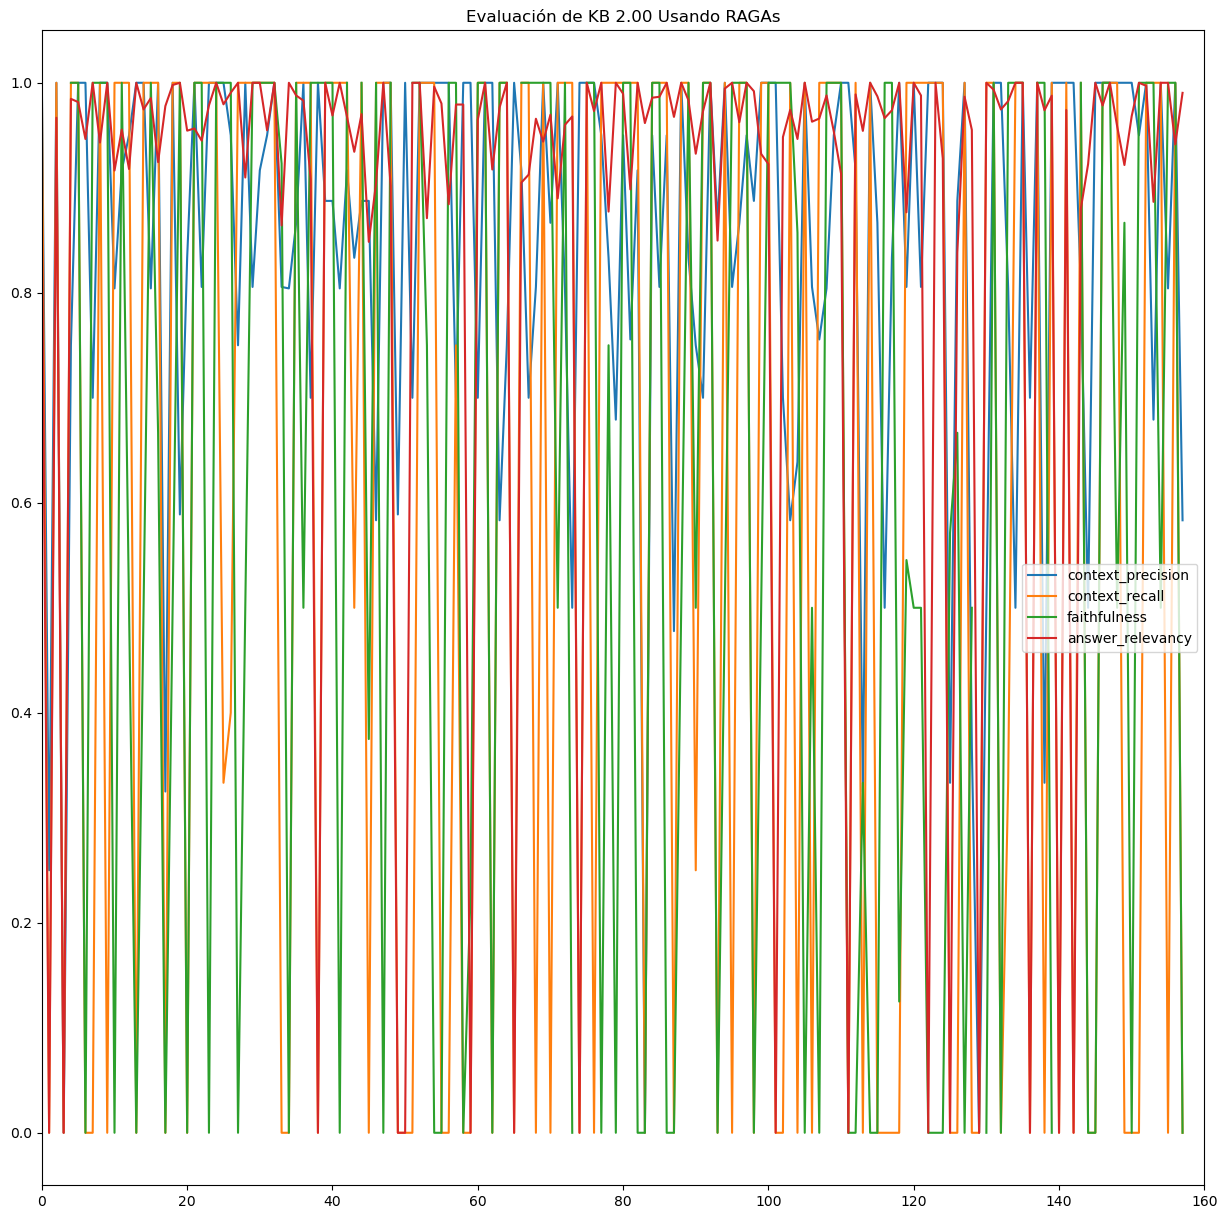

In [75]:
full_results_set_df.plot(
    kind='line',
    y=['context_precision','context_recall','faithfulness','answer_relevancy'],
    xlim=(0,160),
    use_index=True,
    title='Evaluación de KB 2.00 Usando RAGAs',
    figsize=(15, 15)
)

<Axes: title={'center': 'Evaluación de KB 2.00 Usando RAGAs'}>

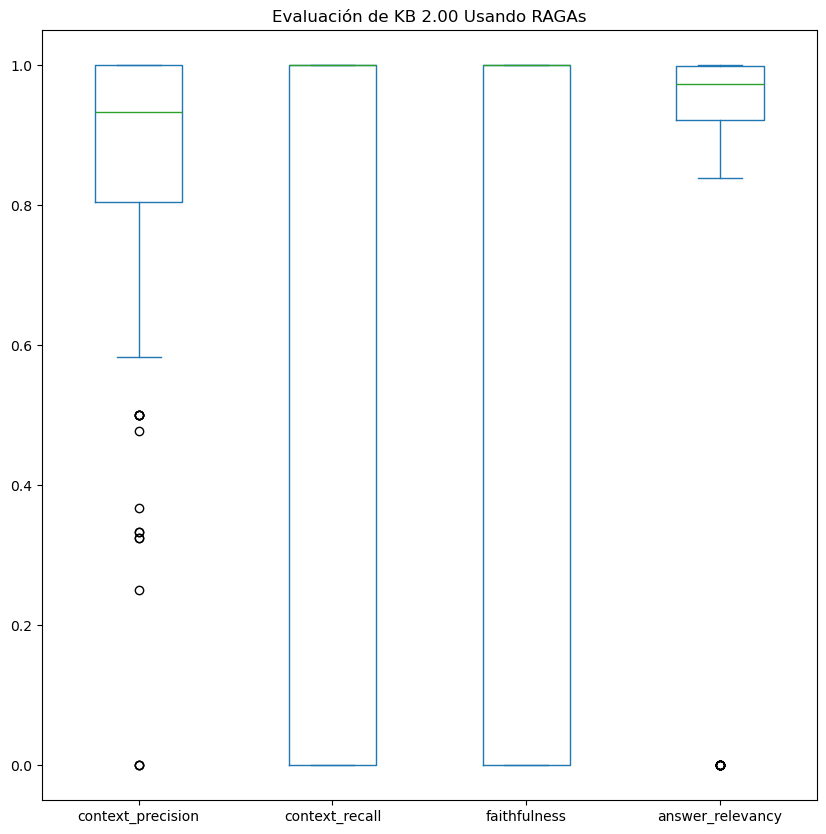

In [77]:
full_results_set_df.plot(
    kind='box',
    y=['context_precision','context_recall','faithfulness','answer_relevancy'],
    use_index=True,
    title='Evaluación de KB 2.00 Usando RAGAs',
    figsize=(10, 10)
)

Mientras que la gráfica de líneas muestra una variación en los resultados, la gráfica de caja muestra que la mediana para todas las métricas está entre 0.8 y 1. En los casos de las métricas de alineación del contexto y de la fidelidad la mediana está cercana a 1.  

**Evaluación de la Métrica de Precisión del Contexto**

Tal y como se pudo de ver en la gráfica de caja, el histograma de la métrica de precisión del contexto indica que más de 120 de las pruebas, fuera de las 158 hechas, tienen un valor de precisión de 0.8 o más, por lo que se puede concluir que el modelo generativo de AWS Bedrock usando la KB V2.00 es muy bueno para recuperar contexto en el orden de importancia más adecuado para contestar la pregunta.

<Axes: title={'center': 'KB 2.00 RAGAs - Precisión de Contexto'}, ylabel='Frequency'>

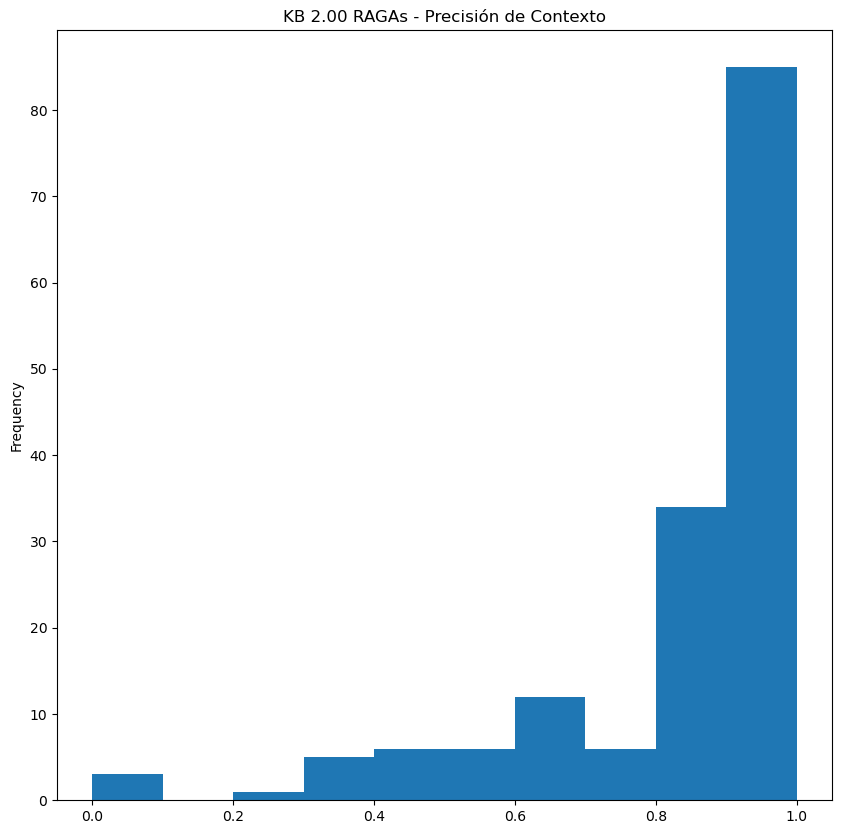

In [73]:
full_results_set_df['context_precision'].plot(
    kind='hist',
    title='KB 2.00 RAGAs - Precisión del Contexto',
    figsize=(10, 10)
)

**Evaluación de la Métrica de Alineación del Contexto**

En lo que respecta a la alineación del contexto se puede observar que el modelo seleccionado recuperas contexto que está alineado con la respuesta correcta en aproximadamente 66% de las ocasiones. Cabe recalcar que esta métrica es muy estricta ya que un cambio del orden de palabras o un saludo al principio de la respuesta da como resultado un valor de 0 (cero), aun y cuando la respuesta es correcta.

<Axes: title={'center': 'KB 2.00 RAGAs - Alineación del Contexto'}, ylabel='Frequency'>

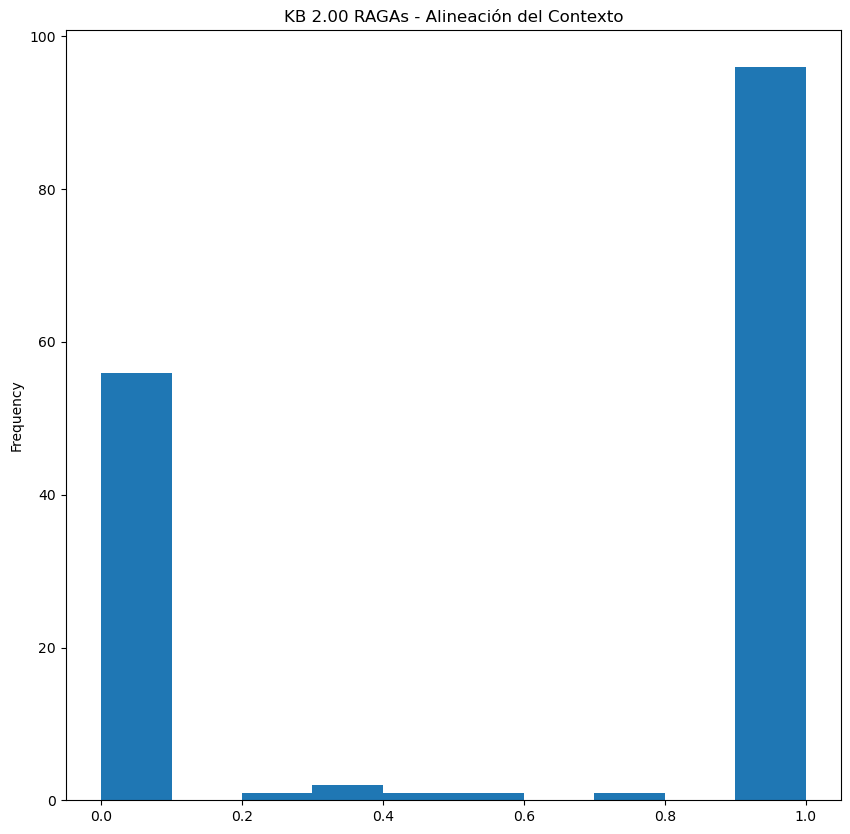

In [74]:
full_results_set_df['context_recall'].plot(
    kind='hist',
    title='KB 2.00 RAGAs - Alineación del Contexto',
    figsize=(10, 10)
)

**Evaluación de la Métrica de Fidelidad**

En está metrica se puede observar un agrupamiento de las respuestas con baja calificación de las respuestas con alta calificación. Como en el caso de la métrica de alineación del contexto, esta métrica es muy estricta ya que un cambio del orden de palabras o un saludo al principio de la respuesta da como resultado un valor de 0 (cero), aun y cuando la respuesta es correcta, pero aun así logro una calificación muy alta en el 50% de las pruebas.

<Axes: title={'center': 'KB 2.00 RAGAs - Fidelidad'}, ylabel='Frequency'>

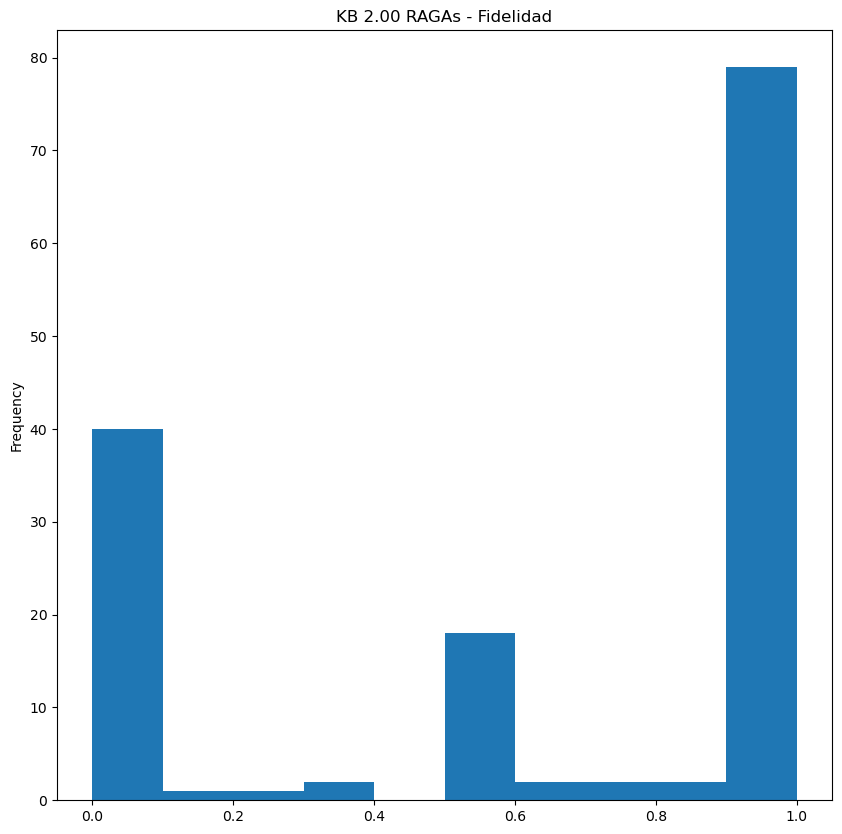

In [72]:
full_results_set_df['faithfulness'].plot(
    kind='hist',
    title='KB 2.00 RAGAs - Fidelidad',
    figsize=(10, 10)
)

**Evaluación de la Métrica de Relevancia de la Respuesta**

Esta es la métrica donde el modelo seleccionado se esmera ya que obtuvo una calificación de 0.8 o más en 80% de las pruebas.

<Axes: title={'center': 'KB 2.00 RAGAs - Relevancia de la Respuesta'}, ylabel='Frequency'>

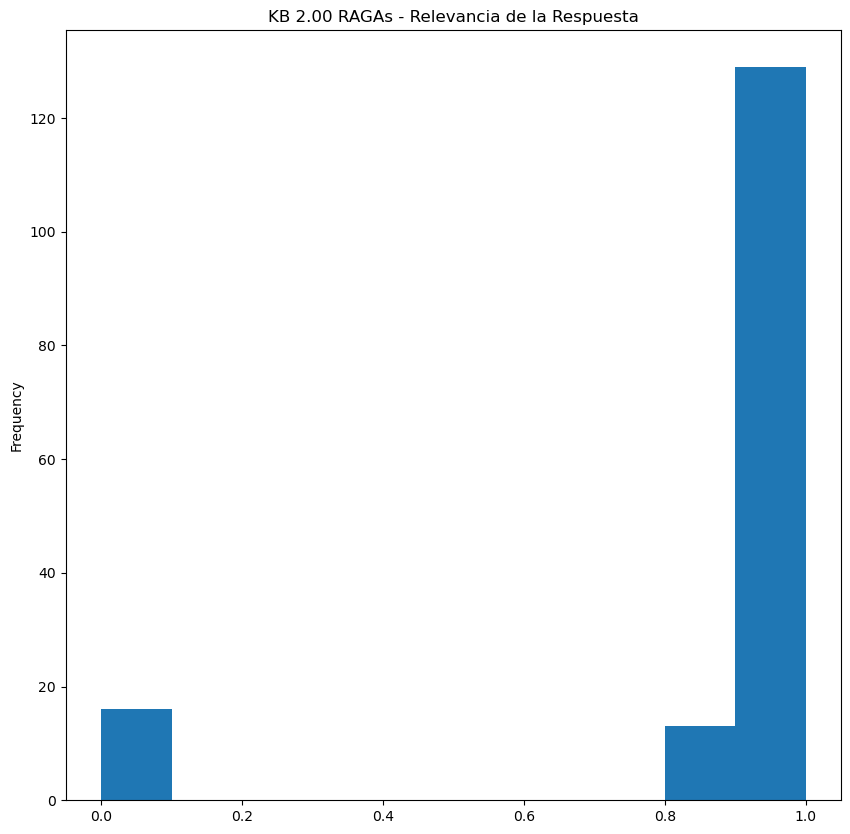

In [71]:
full_results_set_df['answer_relevancy'].plot(
    kind='hist',
    title='KB 2.00 RAGAs - Relevancia de la Respuesta',
    figsize=(10, 10)
)

## **Conclusiones**


Como se indicó anteriormente, ***AWS Bedrock*** ofrece mecanismos para evaluar modelos generativos donde se hace uso de equipos de personas, dentro o fuera de la organización, para evaluar la calidad y la veracidad de las respuestas generadas. En el caso de un modelo generativo asistido por una base de conocimiento en una solución del tipo RAG esto implica no solo revisar la respuesta generada pero los datos de referencia, o contexto, usados para generarla.

Dados los volúmenes de datos y la intensidad laboral requerida es necesario usar otras técnicas de evaluación que permitan automatizar la evaluación con resultados similares a la inspección manual. Para el caso del proyecto de ***Smart Travel Assistant***, se decidió usar las librerías de RAGAs para automatizar la evaluación.

Los resultados obtenidos en la prueba de volumen del modelo seleccionado indican que el **modelo en cuestión es fiable y produce respuestas pertinentes a las preguntas y a la temática**. Si bien algunos resultados apuntan a posibles mejoras de la fuente de datos, también es importante reconocer que la herramienta de evaluación también tiene que mejorar.

Los resultados de la prueba de volumen del modelo seleccionado se encuentran en el archivo ***hotel-data-set-4p-results.xlsx*** en el mismo repositorio de esta libreta.

## **Referencias**

* Es, S., James, J., Espinosa-Anke, L., & Schockaert, S. (2023). RAGAS: Automated Evaluation of Retrieval Augmented Generation. ArXiv (Cornell University). https://doi.org/10.48550/arxiv.2309.15217

* Exploding Gradients. (s.f.). Metrics | Ragas. docs.ragas.io. Recuperado 28 de mayo, 2024, de https://docs.ragas.io/en/stable/concepts/metrics/index.html

* Monigatti, L. (2023, 15 de diciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a


* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html
